# Simulating the same star with multiple PSFs

ScopeSim has several Effect classes to simulate a PSF (Point Spread Function). This notebook verifies that they are all consistent.

In [1]:
%matplotlib inline
import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy import units as u
import yaml
from pprint import pprint
import copy
from astropy.io import fits

import scopesim as sim
import scopesim_templates as sim_tp

## Set up a source with 1 star

We use a single star as source.

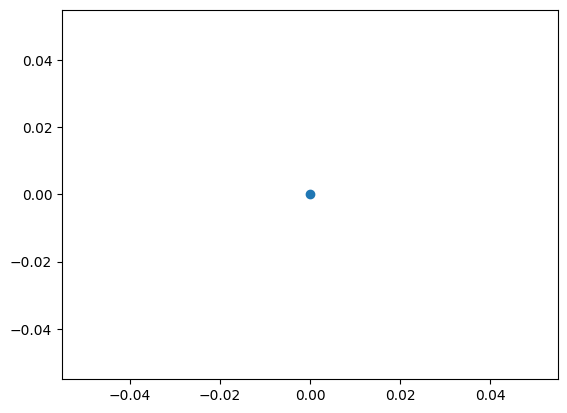

In [2]:
stars = sim_tp.star("Ks", 15)

plt.scatter(stars.fields[0]["x"], stars.fields[0]["y"])

# Setup detectors

We create two detectors, one with an odd number of pixels, and one with an even number of pixels.

In [3]:
yaml_detector_odd = {
    'alias': 'DET',
    'description': 'The detector and electronic properties and effects',
    'name': 'basic_detector',
    'object': 'detector',
    'properties': {
        'dit': '!OBS.dit',
        'image_plane_id': 0,
        'ndit': '!OBS.ndit',
        'temperature': -230,
        'width': 11,
        'height': 11,
        'x': 0,
        'y': 0,
    },
    'effects': [{
        'name': 'detector_window',
        'class': 'DetectorWindow',
        'description': 'Cut-out of the focal plane image with custom dimensions and coordinates',
        'kwargs': {
            'height': '!DET.height',
            'image_plane_id': 0,
            'pixel_size': 0.01,
            'units': 'pixel',
            'width': '!DET.width',
            'x': '!DET.x',
            'y': '!DET.y',
        },
    }],
}

yaml_detector_even = copy.deepcopy(yaml_detector_odd)
yaml_detector_even["properties"]["width"] = 12
yaml_detector_even["properties"]["height"] = 12



In [4]:
yaml_instrument = {
    "object": "instrument",
    "alias": "INST",
    "name": "basic_instrument",
    "description": "Effects from the common optics",
    
    "properties": {
        "temperature": -190.,
        "pixel_scale": 0.2,       # arcsec / pixel
        "plate_scale": 20.,        # arcsec / mm
        # "pixel_size": 0.01,    # mm / pixel
    },
    
    "effects": [{
        "name": "static_surfaces",
        "description": "surfaces list for common optics",
        "class": "SurfaceList",
        "kwargs": {
            # "filename": "INS_common_optics.dat",
            "array_dict": {
                "name": ["entr_window"],
                "outer": [0.5],
                "inner": [0.0],
                "angle": [0.0],
                "temperature": [7.0],
                "action": ["transmission"],
                "filename": ["INS_unity_trans.dat"],
            },
        },
    }],
}

In [5]:
yaml_telescope_seeingpsf = {
    "object": "telescope",
    "alias": "TEL",
    "name": "basic_telescope",
    "description": "The telescope",
    
    "properties": {
        "temperature": 0.,
    },
    
    "effects": [{
        "name": "psf",
        "description": "Seeing limited PSF",
        "class": "SeeingPSF",
        "kwargs": {
            "fwhm": "!OBS.psf_fwhm", # [arcsec]
        },
    }],
}

In [6]:
yaml_telescope_fieldconstantpsf = {
    "object": "telescope",
    "alias": "TEL",
    "name": "basic_telescope",
    "description": "The telescope",
    
    "properties": {
        "temperature": 0.,
    },
    
    "effects": [{
        "name": "psf",
        "description": "Copy of Seeing limited PSF",
        "class": "FieldConstantPSF",
        "kwargs": {
            "filename": "seeingpsfinput.fits", # Created below
        },
    }],
}

## Set up the optical train

An artificial optical train is created.

In [7]:
observation_dict_without_sub_pixel = {
    "!OBS.filter_name_pupil": "Pa-beta",
    "!OBS.filter_name_fw1": "open",
    "!OBS.filter_name_fw2": "open", 
    "!INST.filter_name": "Pa-beta",
    "!OBS.ndit": 20, 
    "!OBS.dit": 3,
    "!OBS.exptime": 60,

    "!OBS.instrument": "MyInstrument",
    "!OBS.catg": "SCIENCE",
    "!OBS.tech": "IMAGE",
    "!OBS.type": "OBJECT",
    "!OBS.mjdobs": datetime.datetime(2022, 1, 1, 2, 30, 0),


    "!OBS.psf_fwhm": 1.5,             # [arcsec]
    "!OBS.slit_name": "narrow",

    "!OBS.include_slit": False,
    "!OBS.include_slicer": False,
    "!OBS.filter_name": "J",

    "!TEL.temperature": 7.0,

    "!INST.temperature": -190,
    "!INST.pixel_scale": 0.2,       # arcsec / pixel
    "!INST.plate_scale": 20,        # arcsec / mm

    "!OBS.modes": ["imaging"],
    "!TEL.telescope": "EvLT",
    "!ATMO.location": "Here",

    # sub_pixel.flag also moves by half a pixel
    "!SIM.sub_pixel.flag": False,
    # "!SIM.sub_pixel.flag": True,
}

observation_dict_with_sub_pixel = copy.copy(observation_dict_without_sub_pixel)
observation_dict_with_sub_pixel["!SIM.sub_pixel.flag"] = True

# Odd number of pixels, no sub pixels

In [8]:
yaml_detector = yaml_detector_odd

In [9]:
observation_dict = observation_dict_without_sub_pixel

## Point source, no PSF

In [10]:
cmd = sim.UserCommands(
    yamls = [
        # yaml_telescope_seeingpsf,

        yaml_instrument,

        yaml_detector,
    ],
    
    properties=copy.deepcopy(observation_dict),
)
opticaltrain = sim.OpticalTrain(cmd)
opticaltrain.observe(stars)
hdus_pointsource = opticaltrain.readout()


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


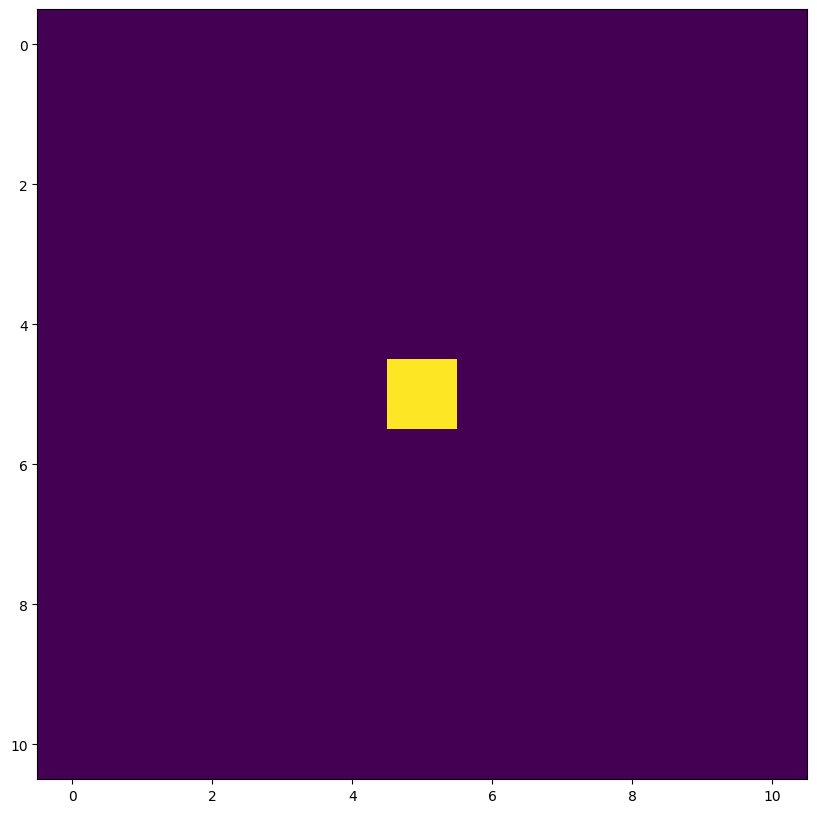

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(hdus_pointsource[0][1].data)

## SeeingPSF

In [12]:
cmd = sim.UserCommands(
    yamls = [
        yaml_telescope_seeingpsf,

        yaml_instrument,

        yaml_detector,
    ],
    
    properties=copy.deepcopy(observation_dict),
)
opticaltrain = sim.OpticalTrain(cmd)
opticaltrain.observe(stars)
hdus_seeingpsf = opticaltrain.readout(filename="seeingpsf.fits")


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


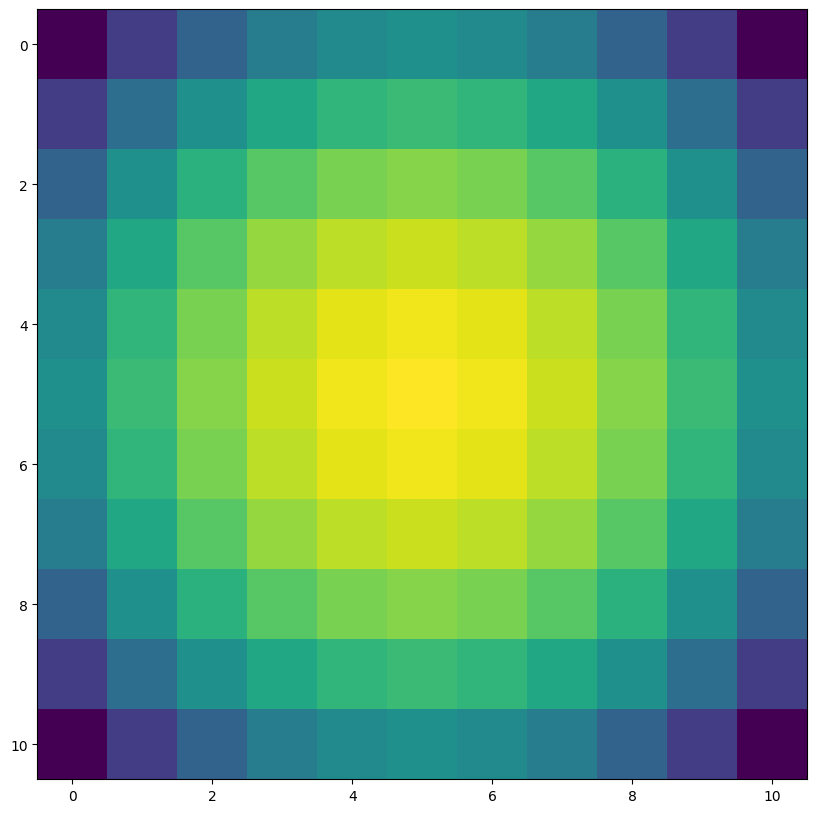

In [13]:
plt.figure(figsize=(10,10))
plt.imshow(hdus_seeingpsf[0][1].data, norm=LogNorm())

In [14]:
hdus = fits.open("seeingpsf.fits")
hdus[1].header["WAVE0"] = 1.6
hdus[1].header
hdus.writeto("seeingpsfinput.fits", overwrite=True)


## FieldConstantPSF

In [15]:
cmd = sim.UserCommands(
    yamls = [
        yaml_telescope_fieldconstantpsf,

        yaml_instrument,

        yaml_detector,
    ],
    
    properties=copy.deepcopy(observation_dict),
)
cmd["!SIM.sub_pixel.flag"]= False
opticaltrain = sim.OpticalTrain(cmd)
opticaltrain.observe(stars)
hdus_fieldconstantpsf = opticaltrain.readout(filename="fieldconstantpsf.fits")


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


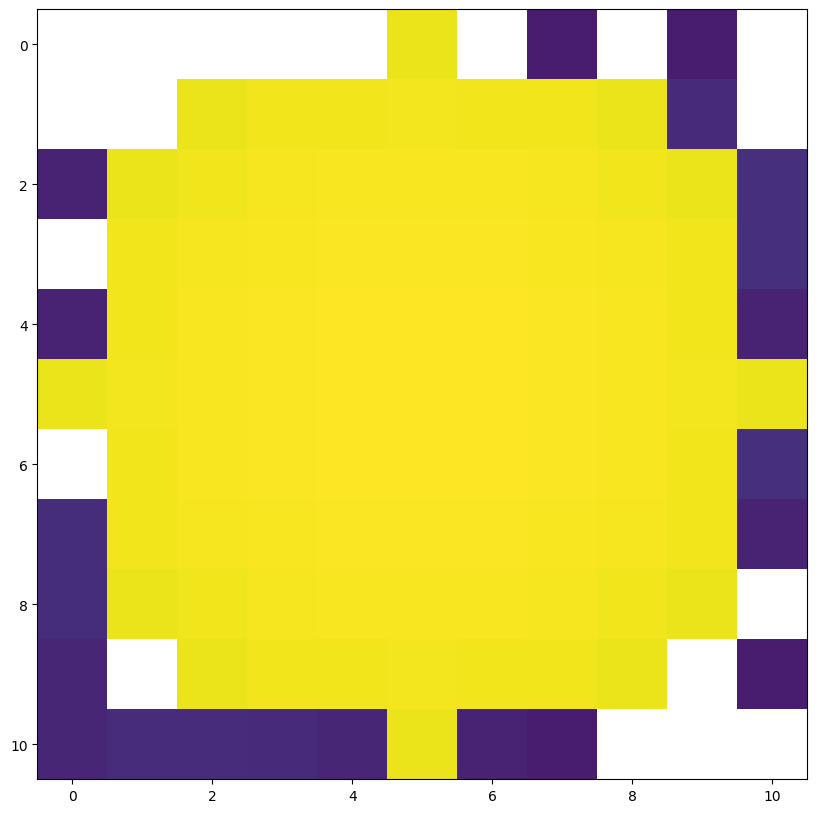

In [16]:
plt.figure(figsize=(10,10))
plt.imshow(hdus_fieldconstantpsf[0][1].data, norm=LogNorm())

In [17]:
set(hdus_fieldconstantpsf[0][1].data.flatten() / hdus_seeingpsf[0][1].data.flatten())

{-9.87959252003631e-16,
 -6.332356935031762e-16,
 -3.4166529439618136e-16,
 -2.5329427740127035e-16,
 -1.5002964962430195e-16,
 -1.212941553355998e-16,
 -1.1992684000432876e-16,
 -1.0031195579219598e-16,
 -9.271214016208757e-17,
 -8.141868433992164e-17,
 -4.862928394443257e-17,
 -3.404612782364612e-17,
 -3.0065753717810094e-17,
 -2.1718247691433834e-17,
 0.0,
 2.2087255308517887e-18,
 8.320412542521424e-18,
 7.677396939547962e-17,
 1.1249712444735775e-16,
 1.2129415533559976e-16,
 1.212941553355998e-16,
 1.2664713870063525e-16,
 1.4053903760554667e-16,
 1.6058213723918294e-16,
 1.7572829823137544e-16,
 1.7963549003857418e-16,
 2.4515725613943086e-16,
 3.7994141610190567e-16,
 4.2830780292903547e-16,
 4.448799646041568e-16,
 5.621561504221865e-16,
 6.517110536393357e-16,
 6.627635900760202e-16,
 6.985100787381525e-16,
 7.185419601542967e-16,
 8.259776734611635e-16,
 8.865299709044465e-16,
 8.89629959160193e-16,
 1.190604508623093,
 1.1906045086230932,
 1.1906045086230934,
 1.19060450862

In [18]:
# So shape is identical, but there is a 19% offset.


## Simulate Source without PSF

In [19]:
hdus = fits.open("seeingpsf.fits")

In [20]:
src = sim.Source(image_hdu=hdus[1], flux=u.Unit("Jy"))

In [21]:
cmd = sim.UserCommands(
    yamls = [
        # yaml_telescope_seeingpsf,

        yaml_instrument,

        yaml_detector,
    ],
    
    properties=copy.deepcopy(observation_dict),
)
opticaltrain = sim.OpticalTrain(cmd)
opticaltrain.observe(src)
hdus_extended = opticaltrain.readout()


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


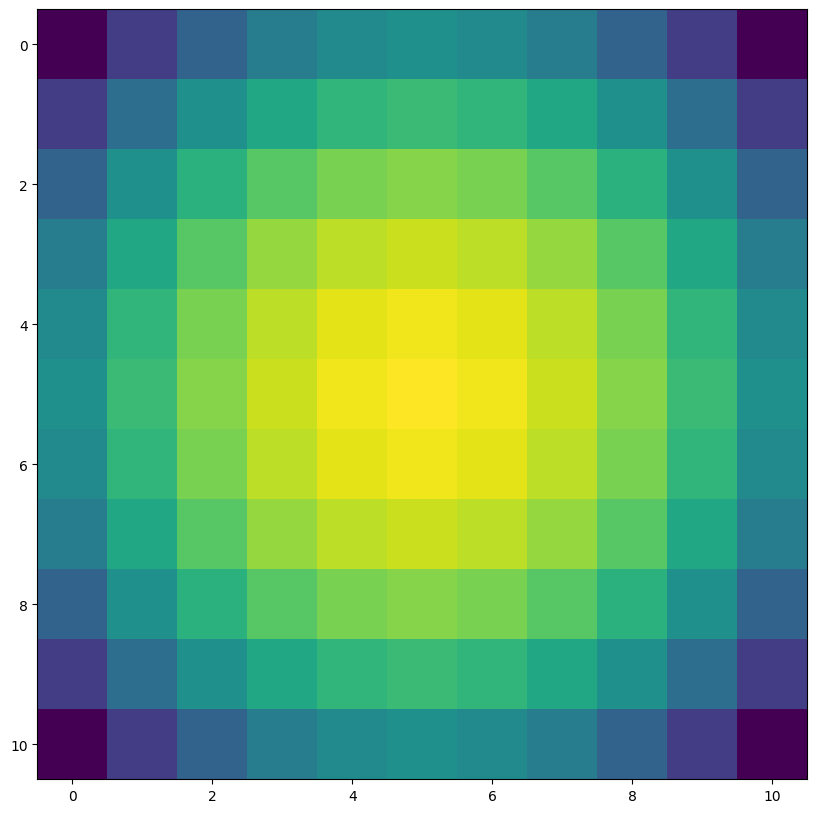

In [22]:
plt.figure(figsize=(10,10))
plt.imshow(hdus_extended[0][1].data, norm=LogNorm())

In [23]:
set(hdus_extended[0][1].data[1:,1:].flatten() / hdus_seeingpsf[0][1].data[:-1,:-1].flatten())

{5143397.052082533,
 5673984.156120619,
 5673984.156120622,
 6259306.034106901,
 6259306.034106905,
 6905009.064282302,
 6905009.064282306,
 6905009.0642823065,
 6905009.064282308,
 7617322.09897032,
 7617322.098970323,
 7617322.098970324,
 7617322.098970328,
 8403116.551953793,
 8403116.551953794,
 8403116.551953796,
 8403116.551953798,
 8403116.5519538,
 9269972.684398487,
 9269972.68439849,
 9269972.684398491,
 9269972.684398493,
 9269972.684398495,
 10226252.728758607,
 10226252.72875861,
 10226252.728758615,
 10226252.728758616,
 11281181.556062873,
 11281181.556062875,
 11281181.556062877,
 11281181.556062879,
 12444935.664747864,
 12444935.664747866,
 12444935.664747868,
 12444935.66474787,
 12444935.664747873,
 13728741.349480163,
 13728741.349480167,
 13728741.34948017,
 13728741.349480173,
 15144982.996964734,
 15144982.996964736,
 15144982.996964738,
 15144982.99696474,
 15144982.996964743,
 15144982.996964745,
 16707322.553428112,
 16707322.553428113,
 16707322.553428117,
 

In [24]:
# So shape is wrong, but ratio is constant

In [25]:
set(hdus_extended[0][1].data.flatten() / hdus_seeingpsf[0][1].data.flatten())

{12444935.664747866, 12444935.664747868, 12444935.66474787}

# Odd number of pixels, with sub pixels

In [26]:
observation_dict = observation_dict_with_sub_pixel

## Point source, no PSF

In [27]:
cmd = sim.UserCommands(
    yamls = [
        # yaml_telescope_seeingpsf,

        yaml_instrument,

        yaml_detector,
    ],
    
    properties=copy.deepcopy(observation_dict),
)
opticaltrain = sim.OpticalTrain(cmd)
opticaltrain.observe(stars)
hdus_pointsource = opticaltrain.readout()


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


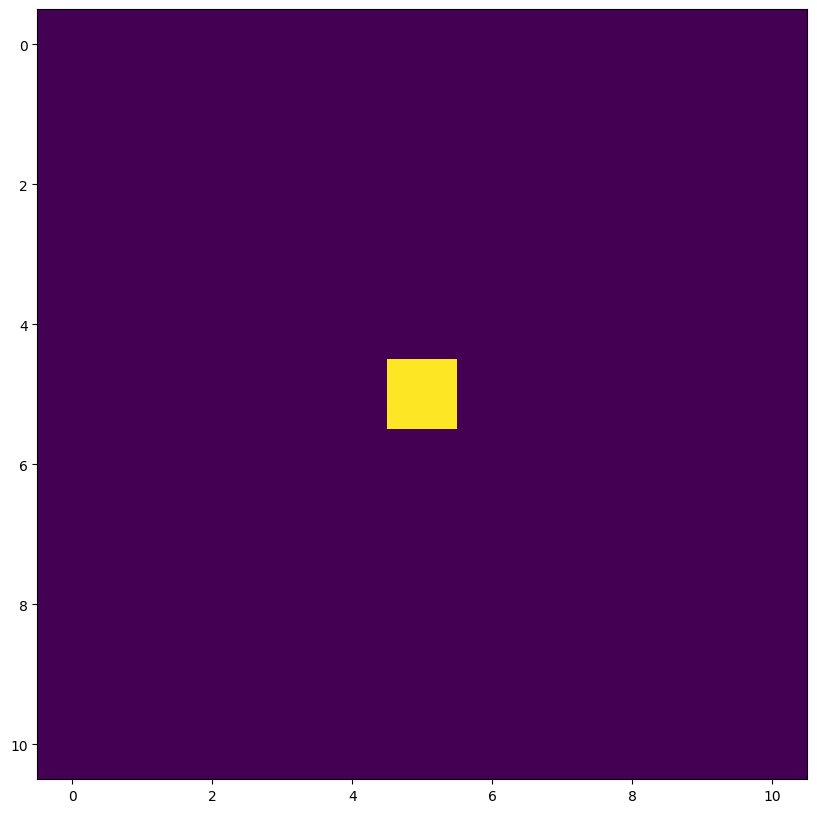

In [28]:
plt.figure(figsize=(10,10))
plt.imshow(hdus_pointsource[0][1].data)

## SeeingPSF

In [29]:
cmd = sim.UserCommands(
    yamls = [
        yaml_telescope_seeingpsf,

        yaml_instrument,

        yaml_detector,
    ],
    
    properties=copy.deepcopy(observation_dict),
)
opticaltrain = sim.OpticalTrain(cmd)
opticaltrain.observe(stars)
hdus_seeingpsf = opticaltrain.readout(filename="seeingpsf.fits")


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


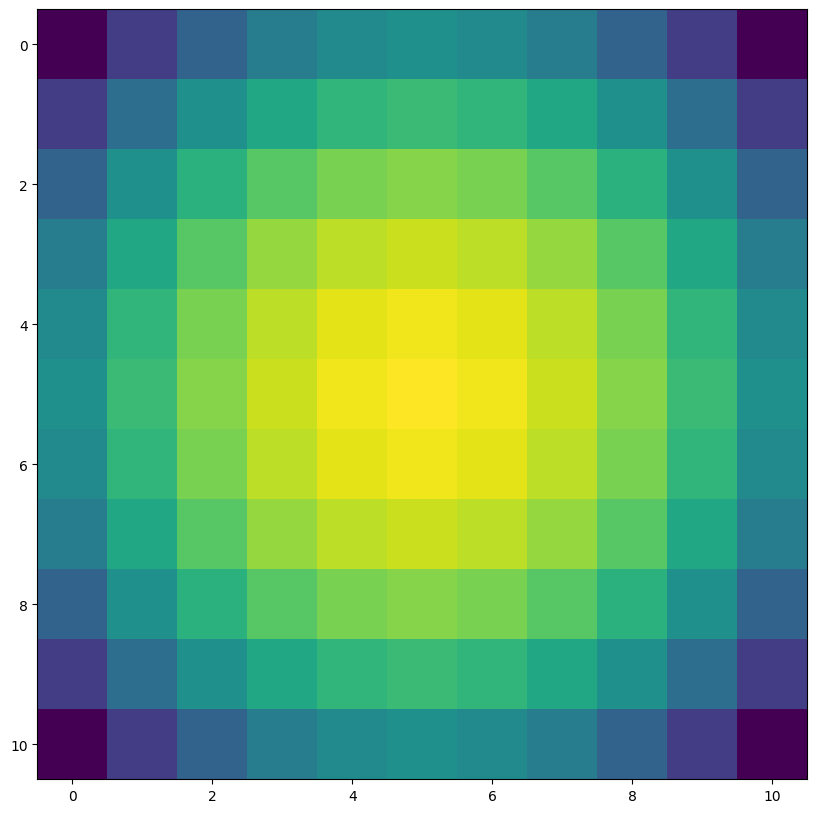

In [30]:
plt.figure(figsize=(10,10))
plt.imshow(hdus_seeingpsf[0][1].data, norm=LogNorm())

In [31]:
hdus = fits.open("seeingpsf.fits")
hdus[1].header["WAVE0"] = 1.6
hdus[1].header
hdus.writeto("seeingpsfinput.fits", overwrite=True)


## FieldConstantPSF

In [32]:
cmd = sim.UserCommands(
    yamls = [
        yaml_telescope_fieldconstantpsf,

        yaml_instrument,

        yaml_detector,
    ],
    
    properties=copy.deepcopy(observation_dict),
)
cmd["!SIM.sub_pixel.flag"]= False
opticaltrain = sim.OpticalTrain(cmd)
opticaltrain.observe(stars)
hdus_fieldconstantpsf = opticaltrain.readout(filename="fieldconstantpsf.fits")


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


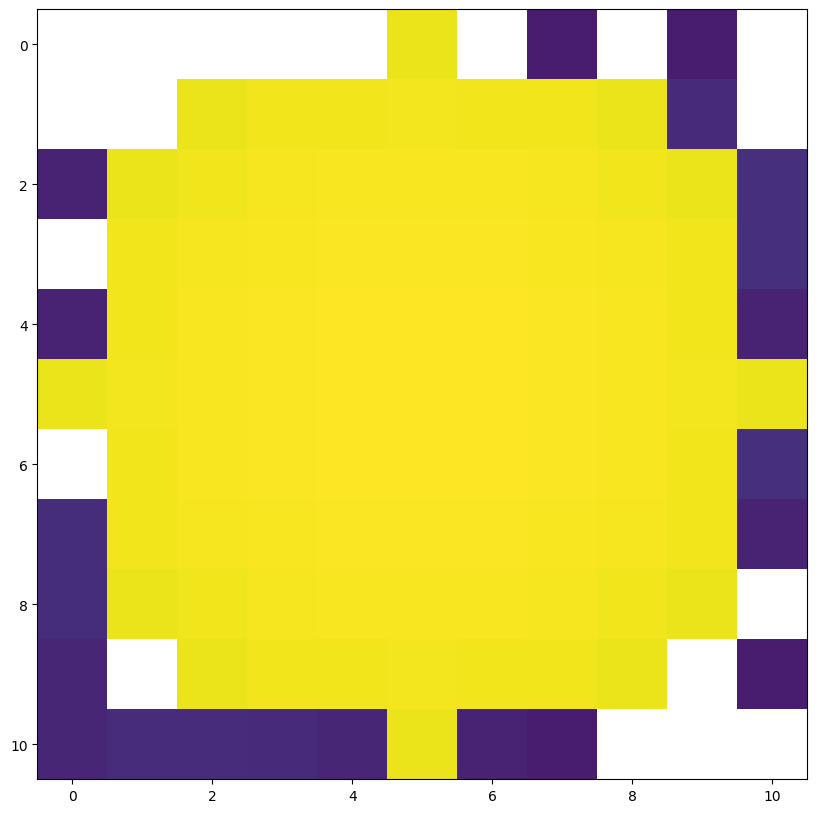

In [33]:
plt.figure(figsize=(10,10))
plt.imshow(hdus_fieldconstantpsf[0][1].data, norm=LogNorm())

In [34]:
set(hdus_fieldconstantpsf[0][1].data.flatten() / hdus_seeingpsf[0][1].data.flatten())

{-9.87959252003631e-16,
 -6.332356935031762e-16,
 -3.4166529439618136e-16,
 -2.5329427740127035e-16,
 -1.5002964962430195e-16,
 -1.212941553355998e-16,
 -1.1992684000432876e-16,
 -1.0031195579219598e-16,
 -9.271214016208757e-17,
 -8.141868433992164e-17,
 -4.862928394443257e-17,
 -3.404612782364612e-17,
 -3.0065753717810094e-17,
 -2.1718247691433834e-17,
 0.0,
 2.2087255308517887e-18,
 8.320412542521424e-18,
 7.677396939547962e-17,
 1.1249712444735775e-16,
 1.2129415533559976e-16,
 1.212941553355998e-16,
 1.2664713870063525e-16,
 1.4053903760554667e-16,
 1.6058213723918294e-16,
 1.7572829823137544e-16,
 1.7963549003857418e-16,
 2.4515725613943086e-16,
 3.7994141610190567e-16,
 4.2830780292903547e-16,
 4.448799646041568e-16,
 5.621561504221865e-16,
 6.517110536393357e-16,
 6.627635900760202e-16,
 6.985100787381525e-16,
 7.185419601542967e-16,
 8.259776734611635e-16,
 8.865299709044465e-16,
 8.89629959160193e-16,
 1.190604508623093,
 1.1906045086230932,
 1.1906045086230934,
 1.19060450862

In [35]:
# So shape is identical, but there is a 19% offset.


## Simulate Source without PSF

In [36]:
hdus = fits.open("seeingpsf.fits")

In [37]:
src = sim.Source(image_hdu=hdus[1], flux=u.Unit("Jy"))

In [38]:
cmd = sim.UserCommands(
    yamls = [
        # yaml_telescope_seeingpsf,

        yaml_instrument,

        yaml_detector,
    ],
    
    properties=copy.deepcopy(observation_dict),
)
opticaltrain = sim.OpticalTrain(cmd)
opticaltrain.observe(src)
hdus_extended = opticaltrain.readout()


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


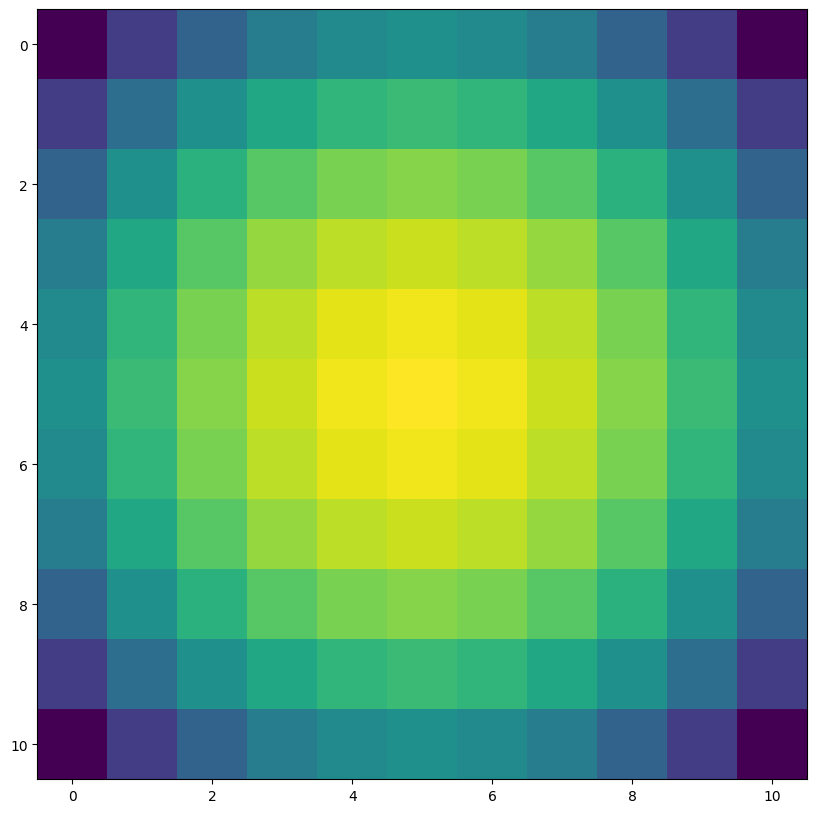

In [39]:
plt.figure(figsize=(10,10))
plt.imshow(hdus_extended[0][1].data, norm=LogNorm())

In [40]:
set(hdus_extended[0][1].data[1:,1:].flatten() / hdus_seeingpsf[0][1].data[:-1,:-1].flatten())

{5143397.052082533,
 5673984.156120619,
 5673984.156120622,
 6259306.034106901,
 6259306.034106905,
 6905009.064282302,
 6905009.064282306,
 6905009.0642823065,
 6905009.064282308,
 7617322.09897032,
 7617322.098970323,
 7617322.098970324,
 7617322.098970328,
 8403116.551953793,
 8403116.551953794,
 8403116.551953796,
 8403116.551953798,
 8403116.5519538,
 9269972.684398487,
 9269972.68439849,
 9269972.684398491,
 9269972.684398493,
 9269972.684398495,
 10226252.728758607,
 10226252.72875861,
 10226252.728758615,
 10226252.728758616,
 11281181.556062873,
 11281181.556062875,
 11281181.556062877,
 11281181.556062879,
 12444935.664747864,
 12444935.664747866,
 12444935.664747868,
 12444935.66474787,
 12444935.664747873,
 13728741.349480163,
 13728741.349480167,
 13728741.34948017,
 13728741.349480173,
 15144982.996964734,
 15144982.996964736,
 15144982.996964738,
 15144982.99696474,
 15144982.996964743,
 15144982.996964745,
 16707322.553428112,
 16707322.553428113,
 16707322.553428117,
 

In [41]:
# So shape is wrong, but ratio is constant

In [42]:
set(hdus_extended[0][1].data.flatten() / hdus_seeingpsf[0][1].data.flatten())

{12444935.664747866, 12444935.664747868, 12444935.66474787}

# Even number of pixels, no sub pixels

In [43]:
yaml_detector = yaml_detector_even

In [44]:
observation_dict = observation_dict_without_sub_pixel

## Point source, no PSF

In [45]:
cmd = sim.UserCommands(
    yamls = [
        # yaml_telescope_seeingpsf,

        yaml_instrument,

        yaml_detector,
    ],
    
    properties=copy.deepcopy(observation_dict),
)
opticaltrain = sim.OpticalTrain(cmd)
opticaltrain.observe(stars)
hdus_pointsource = opticaltrain.readout()


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


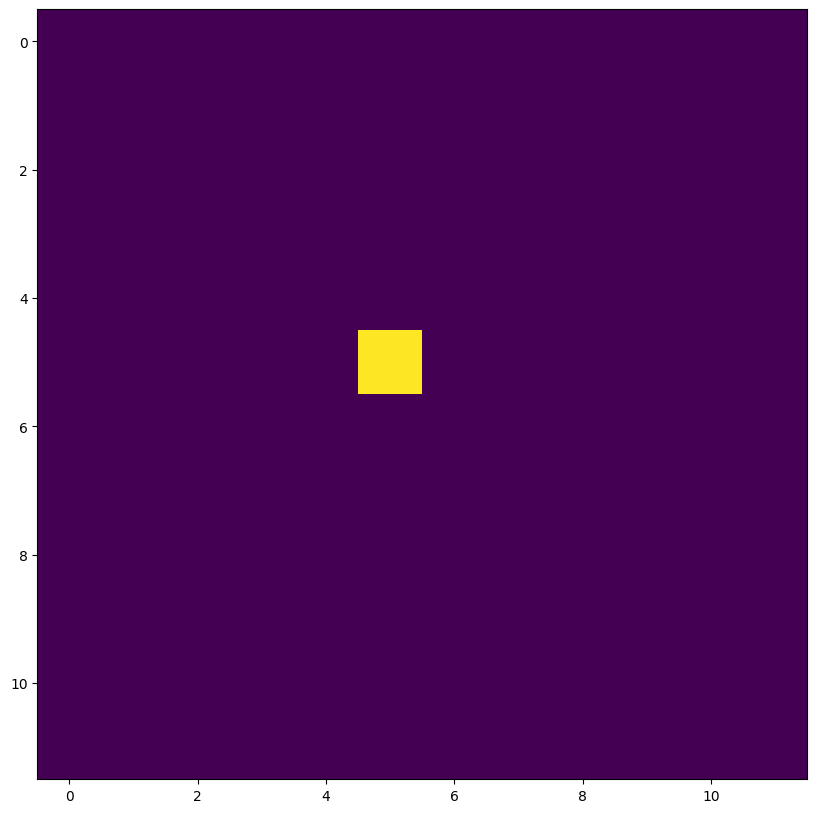

In [46]:
plt.figure(figsize=(10,10))
plt.imshow(hdus_pointsource[0][1].data)

## SeeingPSF

In [47]:
cmd = sim.UserCommands(
    yamls = [
        yaml_telescope_seeingpsf,

        yaml_instrument,

        yaml_detector,
    ],
    
    properties=copy.deepcopy(observation_dict),
)
opticaltrain = sim.OpticalTrain(cmd)
opticaltrain.observe(stars)
hdus_seeingpsf = opticaltrain.readout(filename="seeingpsf.fits")


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


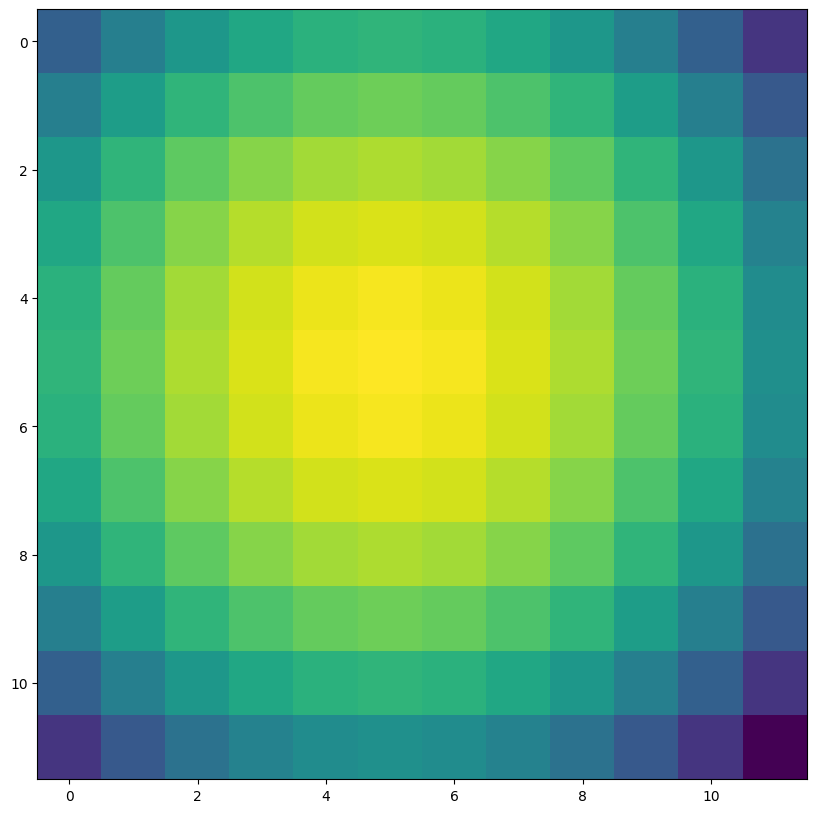

In [48]:
plt.figure(figsize=(10,10))
plt.imshow(hdus_seeingpsf[0][1].data, norm=LogNorm())

In [49]:
hdus = fits.open("seeingpsf.fits")
hdus[1].header["WAVE0"] = 1.6
hdus[1].header
hdus.writeto("seeingpsfinput.fits", overwrite=True)


## FieldConstantPSF

In [50]:
cmd = sim.UserCommands(
    yamls = [
        yaml_telescope_fieldconstantpsf,

        yaml_instrument,

        yaml_detector,
    ],
    
    properties=copy.deepcopy(observation_dict),
)
cmd["!SIM.sub_pixel.flag"]= False
opticaltrain = sim.OpticalTrain(cmd)
opticaltrain.observe(stars)
hdus_fieldconstantpsf = opticaltrain.readout(filename="fieldconstantpsf.fits")


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


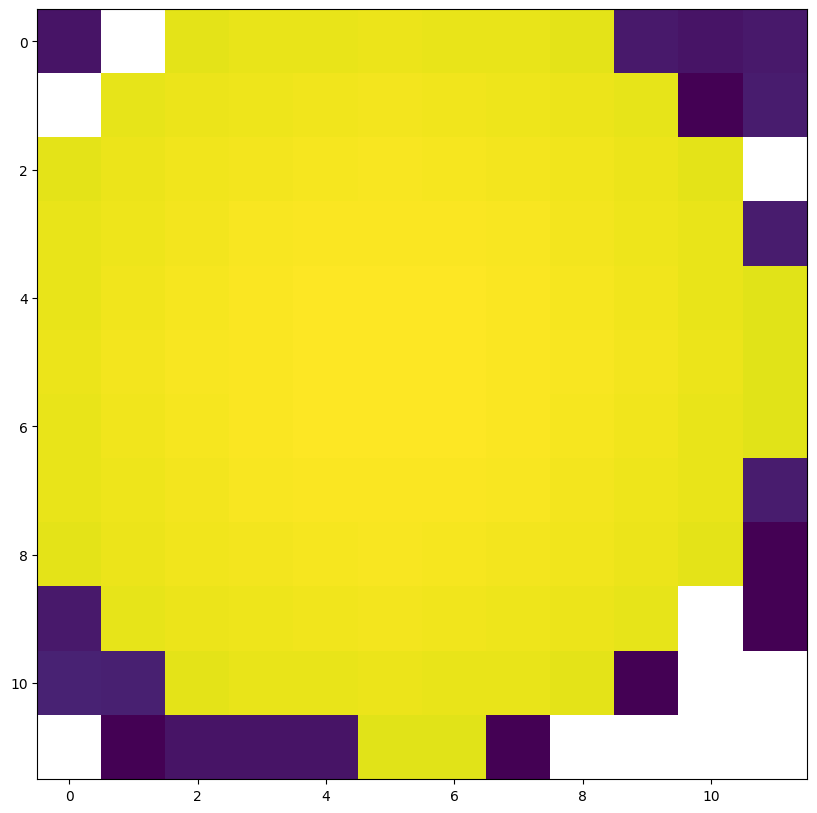

In [51]:
plt.figure(figsize=(10,10))
plt.imshow(hdus_fieldconstantpsf[0][1].data, norm=LogNorm())

In [52]:
set(hdus_fieldconstantpsf[0][1].data.flatten() / hdus_seeingpsf[0][1].data.flatten())

{-2.8361934336188598e-15,
 -1.3521847854765707e-15,
 -1.2329955341873371e-15,
 -1.1152272833008556e-15,
 -8.337148888901922e-16,
 -2.716531620539519e-16,
 -2.5329427740127045e-16,
 -2.0299030018014296e-16,
 -1.3485888655174003e-16,
 -1.2664713870063517e-16,
 -9.271214016208764e-17,
 -1.696749926927382e-17,
 0.0,
 1.2421071542496228e-17,
 5.4330632410790336e-17,
 1.298353537667628e-16,
 1.541244417734171e-16,
 1.6752728152009567e-16,
 2.2339323119593037e-16,
 2.5329427740127055e-16,
 2.9550031183431974e-16,
 3.7994141610190567e-16,
 4.823211875042482e-16,
 6.760923927382857e-16,
 8.232064015541289e-16,
 8.692901185726464e-16,
 1.4775015591715986e-15,
 1.137006637554848,
 1.1370066375548482,
 1.1370066375548484,
 1.1370066375548487,
 1.1370066375548489,
 1.137006637554849,
 1.1370066375548493,
 1.13700663755485}

In [53]:
# So shape is identical, but there is a 19% offset.


## Simulate Source without PSF

In [54]:
hdus = fits.open("seeingpsf.fits")

In [55]:
src = sim.Source(image_hdu=hdus[1], flux=u.Unit("Jy"))

In [56]:
cmd = sim.UserCommands(
    yamls = [
        # yaml_telescope_seeingpsf,

        yaml_instrument,

        yaml_detector,
    ],
    
    properties=copy.deepcopy(observation_dict),
)
opticaltrain = sim.OpticalTrain(cmd)
opticaltrain.observe(src)
hdus_extended = opticaltrain.readout()


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


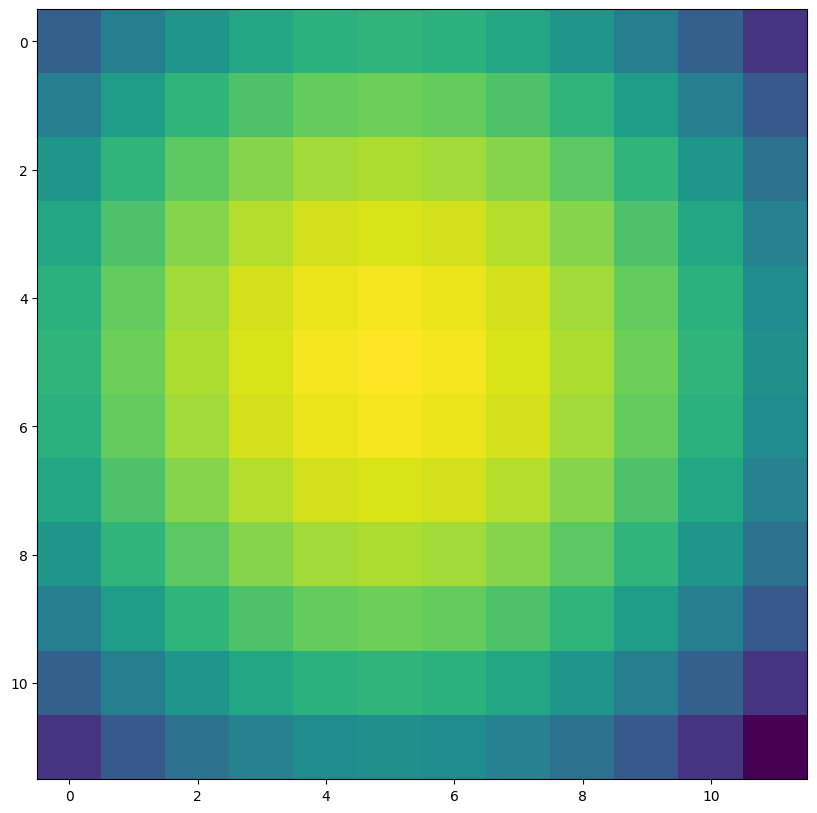

In [57]:
plt.figure(figsize=(10,10))
plt.imshow(hdus_extended[0][1].data, norm=LogNorm())

In [58]:
set(hdus_extended[0][1].data[1:,1:].flatten() / hdus_seeingpsf[0][1].data[:-1,:-1].flatten())

{4226432.305949057,
 4662426.349364112,
 4662426.349364113,
 5143397.052082533,
 5143397.052082534,
 5673984.156120619,
 5673984.156120622,
 5673984.1561206225,
 5673984.156120623,
 6259306.034106899,
 6259306.034106901,
 6259306.034106902,
 6259306.034106905,
 6905009.064282302,
 6905009.064282306,
 6905009.0642823065,
 6905009.064282308,
 6905009.064282309,
 6905009.06428231,
 7617322.098970319,
 7617322.09897032,
 7617322.098970323,
 7617322.098970324,
 7617322.098970328,
 8403116.551953793,
 8403116.551953794,
 8403116.551953796,
 8403116.551953798,
 8403116.5519538,
 8403116.551953802,
 8403116.551953806,
 9269972.684398487,
 9269972.68439849,
 9269972.684398491,
 9269972.684398493,
 9269972.684398495,
 10226252.728758607,
 10226252.72875861,
 10226252.728758615,
 10226252.728758616,
 11281181.556062873,
 11281181.556062875,
 11281181.556062877,
 11281181.556062879,
 11281181.556062883,
 12444935.664747864,
 12444935.664747866,
 12444935.664747868,
 12444935.66474787,
 12444935.66

In [59]:
# So shape is wrong, but ratio is constant

In [60]:
set(hdus_extended[0][1].data.flatten() / hdus_seeingpsf[0][1].data.flatten())

{12444935.664747866, 12444935.664747868, 12444935.66474787}

# Even number of pixels, with sub pixels

In [61]:
yaml_detector = yaml_detector_even

In [62]:
observation_dict = observation_dict_with_sub_pixel

## Point source, no PSF

In [63]:
cmd = sim.UserCommands(
    yamls = [
        # yaml_telescope_seeingpsf,

        yaml_instrument,

        yaml_detector,
    ],
    
    properties=copy.deepcopy(observation_dict),
)
opticaltrain = sim.OpticalTrain(cmd)
opticaltrain.observe(stars)
hdus_pointsource = opticaltrain.readout()


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


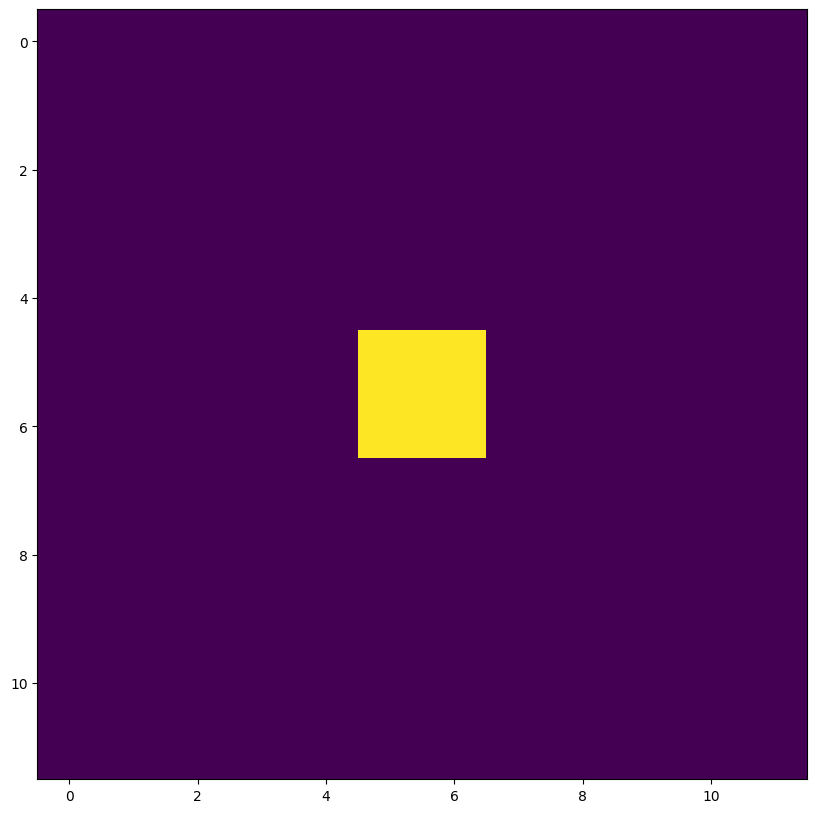

In [64]:
plt.figure(figsize=(10,10))
plt.imshow(hdus_pointsource[0][1].data)

## SeeingPSF

In [65]:
cmd = sim.UserCommands(
    yamls = [
        yaml_telescope_seeingpsf,

        yaml_instrument,

        yaml_detector,
    ],
    
    properties=copy.deepcopy(observation_dict),
)
opticaltrain = sim.OpticalTrain(cmd)
opticaltrain.observe(stars)
hdus_seeingpsf = opticaltrain.readout(filename="seeingpsf.fits")


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


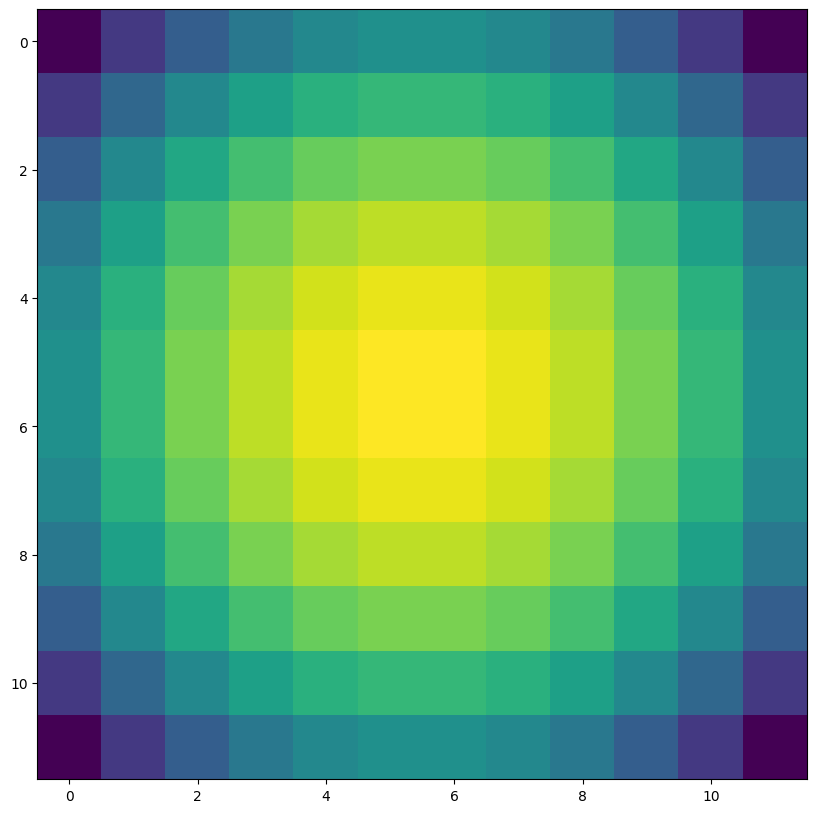

In [66]:
plt.figure(figsize=(10,10))
plt.imshow(hdus_seeingpsf[0][1].data, norm=LogNorm())

In [67]:
hdus = fits.open("seeingpsf.fits")
hdus[1].header["WAVE0"] = 1.6
hdus[1].header
hdus.writeto("seeingpsfinput.fits", overwrite=True)


## FieldConstantPSF

In [68]:
cmd = sim.UserCommands(
    yamls = [
        yaml_telescope_fieldconstantpsf,

        yaml_instrument,

        yaml_detector,
    ],
    
    properties=copy.deepcopy(observation_dict),
)
cmd["!SIM.sub_pixel.flag"]= False
opticaltrain = sim.OpticalTrain(cmd)
opticaltrain.observe(stars)
hdus_fieldconstantpsf = opticaltrain.readout(filename="fieldconstantpsf.fits")


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


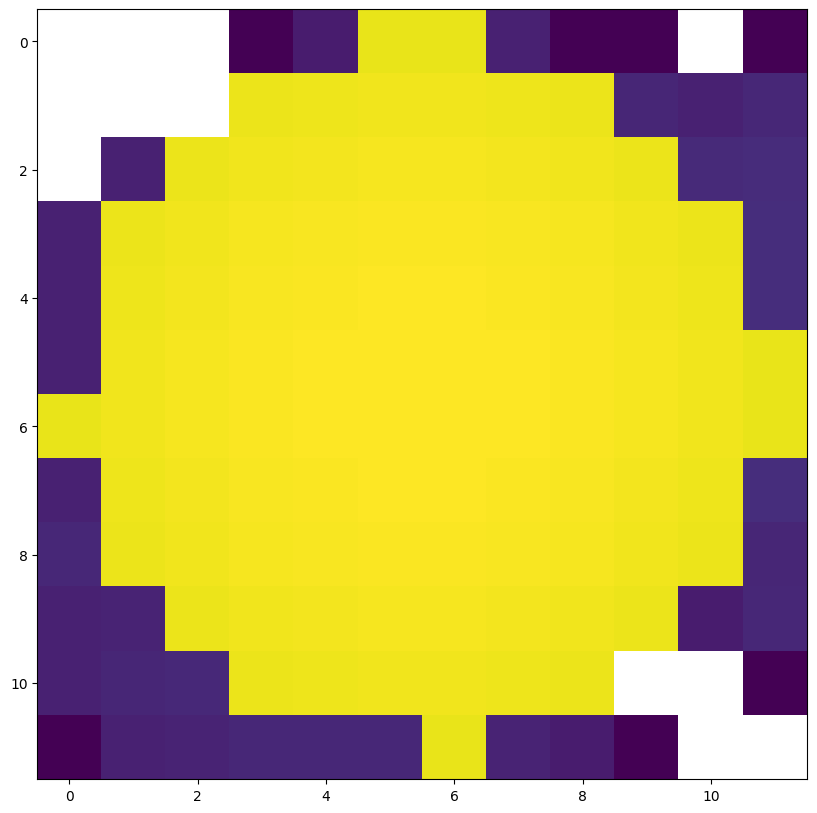

In [69]:
plt.figure(figsize=(10,10))
plt.imshow(hdus_fieldconstantpsf[0][1].data, norm=LogNorm())

In [70]:
set(hdus_fieldconstantpsf[0][1].data.flatten() / hdus_seeingpsf[0][1].data.flatten())

{-8.588115230556295e-16,
 -6.636453081429845e-16,
 -5.844614430136261e-16,
 -5.006154627017434e-16,
 -3.183317167839183e-16,
 -2.65610150690415e-16,
 -2.0563328281403766e-16,
 -1.9482048100454205e-16,
 -1.817699833659897e-16,
 -1.3439982410181903e-16,
 -1.066628351447357e-16,
 -3.320126883630189e-17,
 -2.698672749877719e-17,
 0.0,
 4.9818075298535396e-17,
 6.021360429882223e-17,
 6.371751842860657e-17,
 1.494542258956062e-16,
 1.495079045151241e-16,
 1.593438222271338e-16,
 1.6450662625123016e-16,
 1.6453441189110889e-16,
 1.6453441189110894e-16,
 1.9927230119414163e-16,
 2.1595141560708041e-16,
 2.4675993937684534e-16,
 2.553255147514377e-16,
 2.570850185798577e-16,
 2.65610150690415e-16,
 3.782070023878862e-16,
 3.8964096200908435e-16,
 3.9854460238828346e-16,
 4.179751569349279e-16,
 4.505223623230037e-16,
 4.648177637082264e-16,
 4.665894304866348e-16,
 5.34646535316498e-16,
 5.584852597039997e-16,
 5.97816903582425e-16,
 6.033139164936224e-16,
 6.13947087351335e-16,
 7.96830452071

In [71]:
# So shape is identical, but there is a 19% offset.


## Simulate Source without PSF

In [72]:
hdus = fits.open("seeingpsf.fits")

In [73]:
src = sim.Source(image_hdu=hdus[1], flux=u.Unit("Jy"))

In [74]:
cmd = sim.UserCommands(
    yamls = [
        # yaml_telescope_seeingpsf,

        yaml_instrument,

        yaml_detector,
    ],
    
    properties=copy.deepcopy(observation_dict),
)
opticaltrain = sim.OpticalTrain(cmd)
opticaltrain.observe(src)
hdus_extended = opticaltrain.readout()


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...


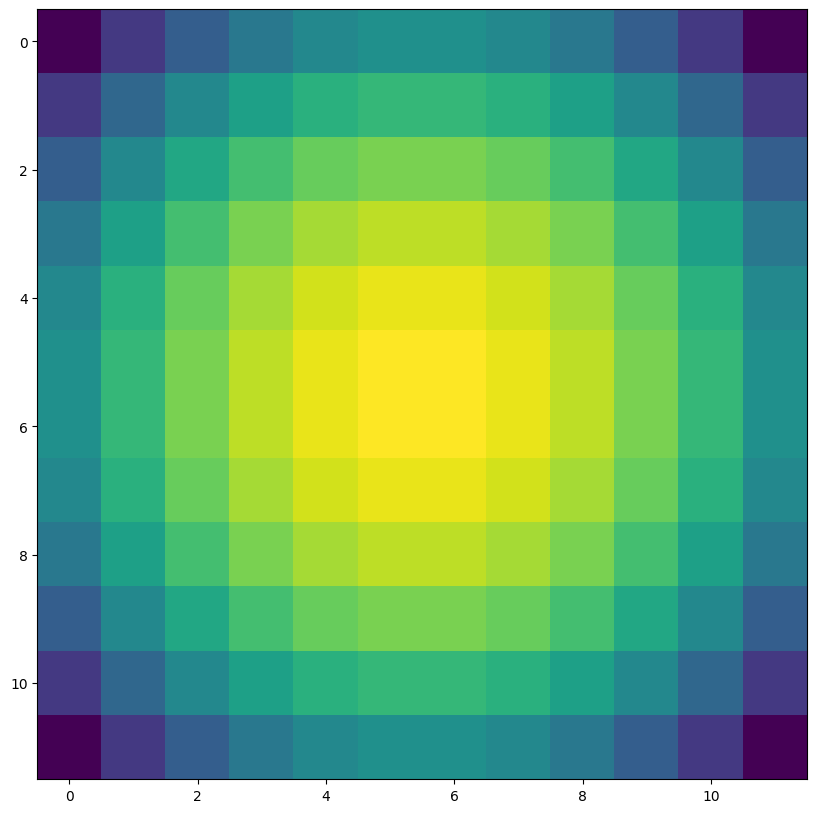

In [75]:
plt.figure(figsize=(10,10))
plt.imshow(hdus_extended[0][1].data, norm=LogNorm())

In [76]:
set(hdus_extended[0][1].data[1:,1:].flatten() / hdus_seeingpsf[0][1].data[:-1,:-1].flatten())

{4773864.753401691,
 5254258.611735874,
 5782739.800080518,
 5782739.800080519,
 5782994.4887585305,
 6364161.479285684,
 6364161.479285689,
 6364656.722281508,
 6364656.722281511,
 7003881.583171722,
 7003881.583171723,
 7004586.846576893,
 7004823.413065276,
 7707816.793897708,
 7707816.793897709,
 7708681.964174988,
 7708681.9641749915,
 7709118.6662086705,
 7709118.666208673,
 8482502.027309746,
 8482502.027309747,
 8483454.152772408,
 8483454.15277241,
 8484032.723632982,
 8484032.723632984,
 8484226.811319496,
 9335155.923001455,
 9335155.923001459,
 9336095.936589051,
 9336095.936589053,
 9336732.657547656,
 9337054.080834223,
 10273752.889152009,
 10273752.88915201,
 10274552.366691304,
 10274552.366691306,
 10275134.427014273,
 10275488.155411407,
 10275488.15541141,
 10275606.822781809,
 11307102.31803071,
 11307102.318030713,
 11307600.315699823,
 11307600.315699827,
 11307982.208216444,
 11308240.898886014,
 11308240.898886016,
 11308371.493091471,
 12444935.664747862,
 124

In [77]:
# So shape is wrong, but ratio is constant

In [78]:
set(hdus_extended[0][1].data.flatten() / hdus_seeingpsf[0][1].data.flatten())

{12444935.664747866, 12444935.664747868, 12444935.66474787}